<a href="https://colab.research.google.com/github/Agnes-FD/Agnes-FD/blob/main/Model_CNN32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [4]:
cd '/content/drive/MyDrive/data'

/content/drive/MyDrive/data


In [5]:
ls

with_mask/  without_mask/


In [6]:
import os
path = '/content/drive/MyDrive/data'
# Membuat Label pada gambar berdasarkan klasifikasi
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(path):
  for name in files:
    full_path.append(os.path.join(path, name))
    tag.append(path.split('/')[-1])
    file_name.append(name)

In [7]:
# Membuat dataframe berdasarkan hasil klasifikasi data yang sudah diberi label
import pandas as pd

df = pd.DataFrame({"path":full_path, "file_name": file_name, "tag":tag})
df.groupby(['tag']).size()

tag
with_mask       3725
without_mask    3858
dtype: int64

In [8]:
# cek data yang sudah diberi label
df

,path,file_name,tag
0,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_3409.jpg,with_mask
1,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_3435.jpg,with_mask
2,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_3402.jpg,with_mask
3,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_3494.jpg,with_mask
4,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask_3499.jpg,with_mask
...,...,...,...
7578,/content/drive/MyDrive/data/without_mask/witho...,without_mask_2074.jpg,without_mask
7579,/content/drive/MyDrive/data/without_mask/witho...,without_mask_2419.jpg,without_mask
7580,/content/drive/MyDrive/data/without_mask/witho...,without_mask_127.jpg,without_mask
7581,/content/drive/MyDrive/data/without_mask/witho...,without_mask_1333 (1).jpg,without_mask


In [9]:
# Membagi dataset menjadi dua bagian (train dan test)
from sklearn.model_selection import train_test_split

x = df['path']
y = df['tag']

x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size= 0.20, random_state=300)
x_test, x_val, y_test, y_val = train_test_split(
    x_test,y_test, test_size=0.5, random_state=100
)

In [10]:


# menyatukan kedalam masing-masing dataframe
df_test = pd.DataFrame({
    'path' : x_test,
    'tag' : y_test,
    'set' : 'test'
})

df_train = pd.DataFrame({
    'path' : x_train,
    'tag' : y_train,
    'set' : 'train'
})
df_val = pd.DataFrame({
    'path' : x_val,
    'tag' : y_val,
    'set' : 'validation'
})

In [11]:
print('train size', len(df_train))
print('test size', len(df_test))
print('validation size', len(df_val))

train size 6066
test size 758
validation size 759


In [12]:
# melihat masing-masing dataset apakah sudah sesuai atau belum
df_all = df_train.append([df_test, df_val]).reset_index(drop=1)

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

df_all.sample(4)


set         tag         
test        with_mask        363
            without_mask     395
train       with_mask       3001
            without_mask    3065
validation  with_mask        361
            without_mask     398
dtype: int64 




,path,tag,set
5803,/content/drive/MyDrive/data/without_mask/witho...,without_mask,train
5374,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask,train
631,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask,train
5736,/content/drive/MyDrive/data/with_mask/with_mas...,with_mask,train


In [13]:
# Memindahkan dataset
import shutil
from tqdm.notebook import tqdm as tq

In [14]:
datasource_path = '/content/drive/MyDrive/data'
dataset_path = '/content/drive/MyDrive/dataset'

In [15]:
for index, row in tq(df_all.iterrows()):
  file_path = row['path']

  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['tag'], row['image'].split('.')[0])

  if os.path.exists(os.path.join(dataset_path, row['set'], row['tag'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['tag']))
  
  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(dataset_path, row['set'], row['tag'], destination_file_name)

  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

In [16]:
# Define Directory
base_dir = '/content/drive/MyDrive/dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'validation')

In [17]:
os.listdir(train_dir)
os.listdir(test_dir)
os.listdir(val_dir)

['with_mask', 'without_mask']

In [18]:
#train test split
from sklearn.model_selection import train_test_split

In [19]:
train_without_mask_dir = os.path.join(train_dir, 'without_mask')
train_with_mask_dir = os.path.join(train_dir, 'with_mask')
test_without_mask_dir = os.path.join(test_dir, 'without_mask')
test_with_mask_dir = os.path.join(test_dir, 'with_mask')
val_without_mask_dir = os.path.join(val_dir, 'without_mask')
val_with_mask_dir = os.path.join(val_dir, 'with_mask')

In [20]:

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.4.1


In [21]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'binary'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'binary'
)
val_generator = datagen.flow_from_directory(
    test_dir,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'binary'
)

Found 6066 images belonging to 2 classes.
Found 758 images belonging to 2 classes.
Found 758 images belonging to 2 classes.


In [22]:
# Membuat Model CNN menggunakan Transfer Learning MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

In [25]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 256)      

In [26]:
print('Compiling Model.......')
model_cnn.compile (optimizer='Adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

Compiling Model.......


In [27]:
import tensorflow as tf

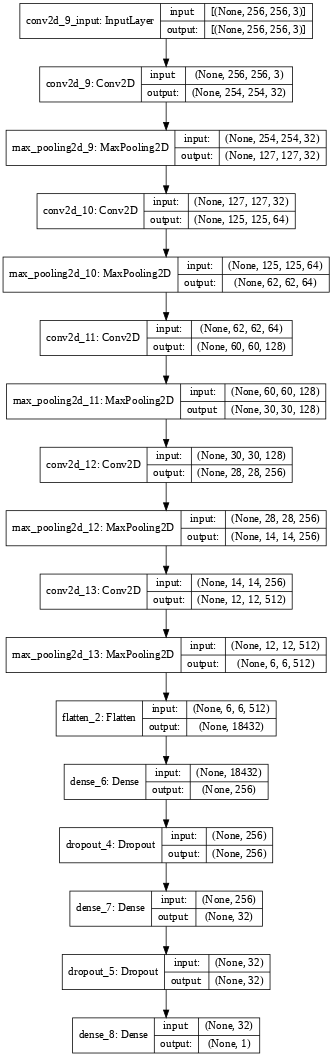

In [28]:
model_viz = tf.keras.utils.plot_model(model_cnn,
                                      to_file='/content/drive/MyDrive/Colab Notebooks/model.png',
                                      show_shapes=True,
                                      rankdir='TB',
                                      expand_nested=True,
                                      dpi=55)
model_viz

In [29]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97):
      print('Akurasi mencapai 97%, proses training dihentikan!')
      self.model.stop_training = True

callbacks = myCallback()

In [30]:
history_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch = 50,
    epochs = 250,
    validation_data = test_generator,
    validation_steps = 10,
    callbacks = [callbacks]
)

Epoch 1/250
50/50 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.5698

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


50/50 [==============================] - 503s 10s/step - loss: 0.6890 - accuracy: 0.5712 - val_loss: 0.5676 - val_accuracy: 0.7781
Epoch 2/250
50/50 [==============================] - 409s 8s/step - loss: 0.3666 - accuracy: 0.8652 - val_loss: 0.2796 - val_accuracy: 0.8969
Epoch 3/250
50/50 [==============================] - 325s 6s/step - loss: 0.3420 - accuracy: 0.8714 - val_loss: 0.2812 - val_accuracy: 0.8719
Epoch 4/250
50/50 [==============================] - 308s 6s/step - loss: 0.3236 - accuracy: 0.8860 - val_loss: 0.2975 - val_accuracy: 0.9000
Epoch 5/250
50/50 [==============================] - 304s 6s/step - loss: 0.2855 - accuracy: 0.9047 - val_loss: 0.2413 - val_accuracy: 0.9125
Epoch 6/250
50/50 [==============================] - 303s 6s/step - loss: 0.3150 - accuracy: 0.8988 - val_loss: 0.2446 - val_accuracy: 0.9125
Epoch 7/250
50/50 [==============================] - 300s 6s/step - loss: 0.2430 - accuracy: 0.9336 - val_loss: 0.2171 - val_accuracy: 0.9250
Epoch 8/250
50/50

In [31]:
from matplotlib import pyplot as plt

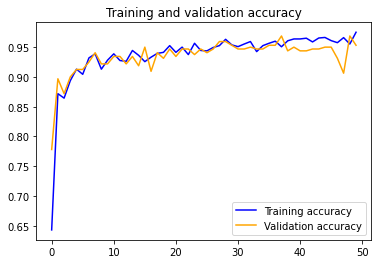

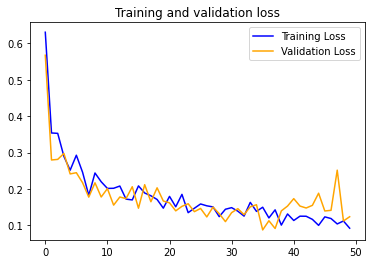

In [32]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
cd'/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [34]:
#save model
import os
MODEL_BASE_PATH = "Model"
PROJECT_NAME ="CNN"
SAVE_MODEL_NAME = "Model_CNN32.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))
    
print('Saving Model At {}...'.format(save_model_path))
model_cnn.save(save_model_path,include_optimizer=False)

Saving Model At Model/CNN/Model_CNN32.h5...
